In [142]:
%reload_ext autoreload
%autoreload 2

import os
import sys
user_name = os.getlogin()
anatree_path = f'/home/{user_name}/apc_atmo_repo/Anatree/'
if not anatree_path in sys.path:
    sys.path.append(anatree_path)
from anatree_class import Anatree
import polars as pl
import matplotlib.pyplot as plt
from math import pi
from ana_tools import *
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d

plt.rcParams.update({'font.size': 16})

In [143]:
def create_division(df:pl.DataFrame, particle, axes = ['x','y','z']):
    list_ndf = [f'trkpidndf_pandoraTrack_{ax}' for ax in axes]

    for ax in axes:
        name_of_div_col = f'div_{particle}_{ax}'
        df = df.select(
            pl.all(),
            (pl.col(f'trkpidchi{particle}_pandoraTrack_{ax}')/pl.col(f'trkpidndf_pandoraTrack_{ax}')).alias(name_of_div_col)
        ).with_columns(
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') <0 ).then(None).otherwise(pl.col(name_of_div_col)).alias(name_of_div_col),
            pl.when(pl.col(f'trkpidndf_pandoraTrack_{ax}') <0 ).then(0).otherwise(1).alias(f'ndiv_{ax}'),
        )

    list_sum = [f'div_{particle}_{ax}' for ax in axes]
    list_div = [f'ndiv_{ax}' for ax in axes]

    df = df.with_columns( #first minimum, that works with nan
        (pl.min_horizontal(list_sum)).alias(f'trkpid{particle}_min'),
    ).fill_null(0).with_columns(
        (pl.sum_horizontal(list_sum)/pl.sum_horizontal(list_div)).alias(f'trkpid{particle}_av'),
        pl.max_horizontal(list_ndf).alias(f'trkpid{particle}_max')
       
    )
    return df
def pid_eval(df):
    df = create_division(df,'pr')
    df = create_division(df,'ka')
    df = create_division(df,'pi')
    df = create_division(df,'mu')
    return df

def particle_selection(df:pl.DataFrame, type='av'):
    """
    Make pid selection based on different methods
    type: list(str)
        `av` for average between chi2 x,y,z  \n
        `min` for getting minimum chi2/ndf  \n
        `max` for getting chi2 with maximum ndf  \n
    """

    df = df.with_columns(
        min_pid = pl.min(f'trkpidpr_{type}',f'trkpidka_{type}', f'trkpidpi_{type}',f'trkpidmu_{type}')
    ).with_columns(
        pid = pl.when(pl.col(f'trkpidpr_{type}')==pl.col('min_pid')).then(2212).otherwise(
        pl.when(pl.col(f'trkpidka_{type}')==pl.col('min_pid')).then(321).otherwise(
        pl.when(pl.col(f'trkpidpi_{type}')==pl.col('min_pid')).then(211).otherwise(
        pl.when(pl.col(f'trkpidmu_{type}')==pl.col('min_pid')).then(13).otherwise(
        0))))
    )

    return df

In [144]:
# anatree = Anatree("../anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree = Anatree.from_parquet('parquet',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
pfp = anatree.pfp
merged:pl.DataFrame
merged = 0
for i,n in enumerate(nu):
    df = anatree.get_full_pfp(pfp[i], showers[i], tracks[i], geant[i], nu[i])
    df = df.collect()
    if i == 0:
        merged = df
    else:
        merged = pl.concat([merged,df])

pfp = merge_same_df(anatree.pfp)
nu = merge_same_df(anatree.nu)
reco_tracks = merge_same_df(anatree.reco_tracks)
reco_showers = merge_same_df(anatree.reco_showers)

# pfp_merged = pfp.drop('pfp_parentID').join(
#     reco_tracks,
#     how='left',
#     right_on=selection_events('trkPFParticleID_pandoraTrack'),
#     left_on=selection_events('pfp_selfID')
#     ).join(
#         reco_showers,
#         how='left',
#         right_on=selection_events('shwr_PFParticleID_pandoraShower'),
#         left_on=selection_events('pfp_selfID')
#     ).join(
#         nu,
#         how='left',
#         on=selection_events()
#     )
pfp_merged = pid_eval(merged.filter(pl.col('has_valid_pfp') == 1))

# anatree = Anatree("/home/pgranger/atmospherics/anatree_hd_AV_sum.root")

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [145]:
numu_cc = pfp_merged.filter(
    pl.col('nuPDG_truth') == 14
).filter(
    pl.col('ccnc_truth') == 0
)

numubar_cc = pfp_merged.filter(
    pl.col('nuPDG_truth') == -14
).filter(
    pl.col('ccnc_truth') == 0
)

numu_cc.columns

['subrun',
 'event',
 'pfp_selfID',
 'pfp_isPrimary',
 'pfp_numDaughters',
 'pfp_vertexID',
 'pfp_isShower',
 'pfp_isTrack',
 'pfp_trackID',
 'pfp_showerID',
 'pfp_pdgCode',
 'pfp_isNeutrino',
 'trkId_pandoraTrack',
 'trkke_pandoraTrack_x',
 'trkke_pandoraTrack_y',
 'trkke_pandoraTrack_z',
 'trkrange_pandoraTrack_x',
 'trkrange_pandoraTrack_y',
 'trkrange_pandoraTrack_z',
 'trkidtruth_pandoraTrack_x',
 'trkidtruth_pandoraTrack_y',
 'trkidtruth_pandoraTrack_z',
 'trkorigin_pandoraTrack_x',
 'trkorigin_pandoraTrack_y',
 'trkorigin_pandoraTrack_z',
 'trkpdgtruth_pandoraTrack_x',
 'trkpdgtruth_pandoraTrack_y',
 'trkpdgtruth_pandoraTrack_z',
 'trkefftruth_pandoraTrack_x',
 'trkefftruth_pandoraTrack_y',
 'trkefftruth_pandoraTrack_z',
 'trkpurtruth_pandoraTrack_x',
 'trkpurtruth_pandoraTrack_y',
 'trkpurtruth_pandoraTrack_z',
 'trkpitchc_pandoraTrack_x',
 'trkpitchc_pandoraTrack_y',
 'trkpitchc_pandoraTrack_z',
 'ntrkhits_pandoraTrack_x',
 'ntrkhits_pandoraTrack_y',
 'ntrkhits_pandoraTrack_z'

['subrun', 'event']
['subrun', 'event', 'longest_track']
['subrun', 'event', 'pfp_selfID']


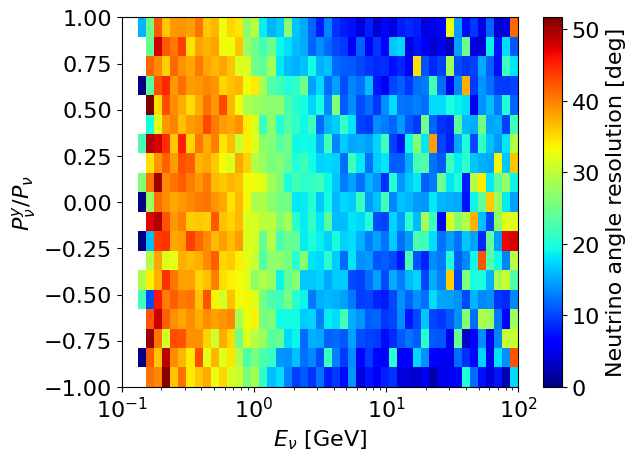

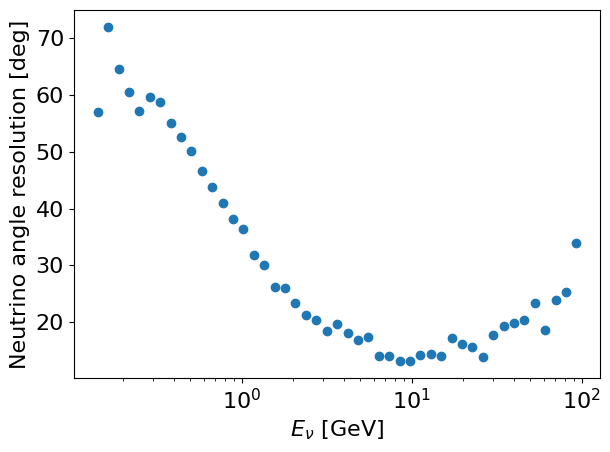

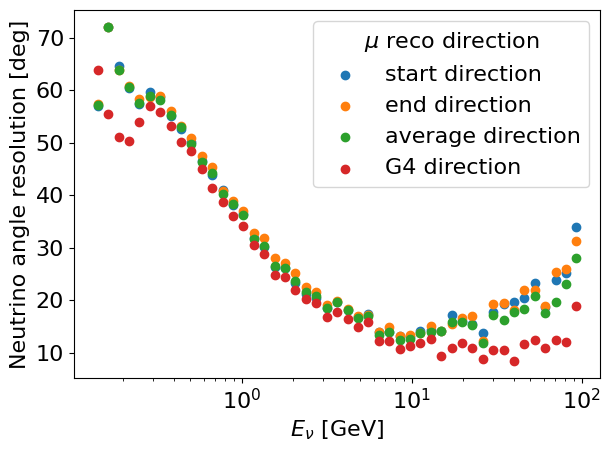

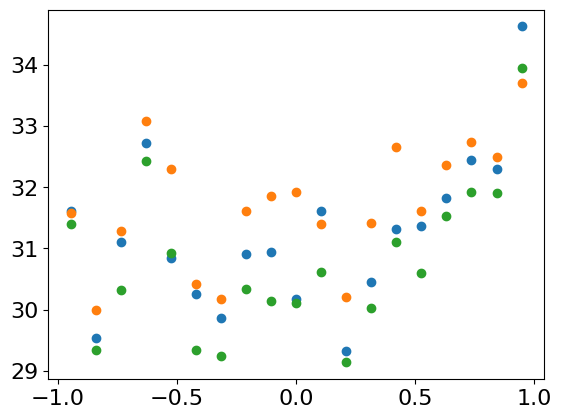

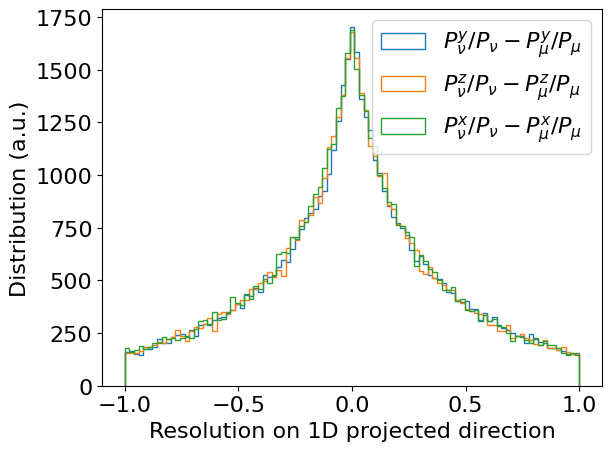

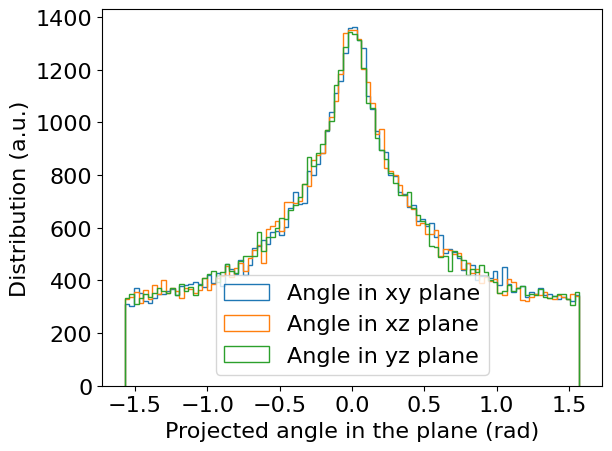

In [154]:
def projected_2d_angle(plane='xy', vec1_template='nu_dcos_{}', vec2_template='mu_dcos{}_start'):
    assert(len(plane) == 2)
    p1, p2 = plane[0], plane[1]
    v11, v12 = pl.col(vec1_template.format(p1)), pl.col(vec1_template.format(p2))
    v21, v22 = pl.col(vec2_template.format(p1)), pl.col(vec2_template.format(p2))
    scalar = v11*v22 - v12*v21
    norm = (v11**2 + v12**2).sqrt()*(v21**2 + v22**2).sqrt()
    return (scalar/norm).arcsin()

result = numu_cc.group_by(selection_events()).agg(
    longest_track = pl.col('pfp_selfID')
                            .sort_by('trklen_pandoraTrack')
                            .filter(is_track())
                            .filter(is_primary_reco())
                            .last()
).join(
    numu_cc,
    left_on=selection_events('longest_track'),
    right_on=selection_events('pfp_selfID'),
    how='left'
).select(
    Ev = pl.col('enu_truth'),
    nu_dcos_y = pl.col('nu_dcosy_truth'),
    nu_dcos_x = pl.col('nu_dcosx_truth'),
    nu_dcos_z = pl.col('nu_dcosz_truth'),
    mu_dcosx_start = pl.col('trkstartdcosx_pandoraTrack'),
    mu_dcosy_start = pl.col('trkstartdcosy_pandoraTrack'),
    mu_dcosz_start = pl.col('trkstartdcosz_pandoraTrack'),
    mu_dcosx_end = pl.col('trkenddcosx_pandoraTrack'),
    mu_dcosy_end = pl.col('trkenddcosy_pandoraTrack'),
    mu_dcosz_end = pl.col('trkenddcosz_pandoraTrack'),
    mu_dcosx_g4 = pl.col('Px_geant')/pl.col('P_geant'),
    mu_dcosy_g4 = pl.col('Py_geant')/pl.col('P_geant'),
    mu_dcosz_g4 = pl.col('Pz_geant')/pl.col('P_geant'),
).with_columns(
    ang_xy = projected_2d_angle('xy'),
    ang_xz = projected_2d_angle('xz'),
    ang_yz = projected_2d_angle('yz'),
)

Ebins = np.logspace(-1, 2, 50)
angbins = np.linspace(-1, 1, 20)
plt.figure()
std, _, _, _ = binned_statistic_2d(result['Ev'], result['nu_dcos_y'], (result['nu_dcos_y'] - result['mu_dcosy_start'])*180/np.pi, statistic=manual_std, bins=(Ebins, angbins))
plt.pcolormesh(Ebins, angbins, std.T, cmap='jet')
plt.colorbar(label="Neutrino angle resolution [deg]")
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$P_\nu^y/P_\nu$")
plt.xscale('log')

plt.figure()
std, _, _ = binned_statistic(result['Ev'], (result['nu_dcos_y'].arccos() - result['mu_dcosy_start'].arccos())*180/np.pi, statistic=manual_std, bins=Ebins)
plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="start direction")
plt.xscale('log')
plt.ylabel('Neutrino angle resolution [deg]')
plt.xlabel(r'$E_\nu$ [GeV]')
plt.tight_layout()

plt.figure()
std, _, _ = binned_statistic(result['Ev'], (result['nu_dcos_y'].arccos() - result['mu_dcosy_start'].arccos())*180/np.pi, statistic=manual_std, bins=Ebins)
plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="start direction")
std, _, _ = binned_statistic(result['Ev'], (result['nu_dcos_y'].arccos() - result['mu_dcosy_end'].arccos())*180/np.pi, statistic=manual_std, bins=Ebins)
plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="end direction")
std, _, _ = binned_statistic(result['Ev'], (result['nu_dcos_y'].arccos() - 0.5*result['mu_dcosy_end'].arccos() - 0.5*result['mu_dcosy_start'].arccos())*180/np.pi, statistic=manual_std, bins=Ebins)
plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="average direction")
std, _, _ = binned_statistic(result['Ev'], (result['nu_dcos_y'].arccos() - result['mu_dcosy_g4'].arccos())*180/np.pi, statistic=manual_std, bins=Ebins)
plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="G4 direction")
plt.xscale('log')
plt.legend(title=r"$\mu$ reco direction")
plt.ylabel('Neutrino angle resolution [deg]')
plt.xlabel(r'$E_\nu$ [GeV]')
plt.tight_layout()

plt.figure()
std, _, _ = binned_statistic(result['nu_dcos_y'], (result['nu_dcos_y'] - result['mu_dcosy_start'])*180/np.pi, statistic=manual_std, bins=angbins)
plt.scatter(0.5*(angbins[:-1] + angbins[1:]), std)
std, _, _ = binned_statistic(result['nu_dcos_y'], (result['nu_dcos_y'] - result['mu_dcosy_end'])*180/np.pi, statistic=manual_std, bins=angbins)
plt.scatter(0.5*(angbins[:-1] + angbins[1:]), std)
std, _, _ = binned_statistic(result['nu_dcos_y'], (result['nu_dcos_y'] - 0.5*result['mu_dcosy_end'] - 0.5*result['mu_dcosy_start'])*180/np.pi, statistic=manual_std, bins=angbins)
plt.scatter(0.5*(angbins[:-1] + angbins[1:]), std)
# plt.xscale('log')


plt.figure()
bins = np.linspace(-1, 1, 100)
plt.hist(result['nu_dcos_y'] - result['mu_dcosy_start'], bins=bins, histtype='step', label=r"$P_\nu^y/P_\nu - P_\mu^y/P_\mu$");
plt.hist(result['nu_dcos_z'] - result['mu_dcosz_start'], bins=bins, histtype='step', label=r"$P_\nu^z/P_\nu - P_\mu^z/P_\mu$");
plt.hist(result['nu_dcos_x'] - result['mu_dcosx_start'], bins=bins, histtype='step', label=r"$P_\nu^x/P_\nu - P_\mu^x/P_\mu$");
plt.ylabel("Distribution (a.u.)")
plt.xlabel("Resolution on 1D projected direction")
plt.legend()
plt.tight_layout()

plt.figure()
plt.hist(result['ang_xy'], bins=100, histtype='step', label="Angle in xy plane");
plt.hist(result['ang_xz'], bins=100, histtype='step', label="Angle in xz plane");
plt.hist(result['ang_yz'], bins=100, histtype='step', label="Angle in yz plane");
plt.xlabel("Projected angle in the plane (rad)")
plt.ylabel("Distribution (a.u.)")
plt.legend(loc='lower center')
plt.tight_layout()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'P [GeV]')

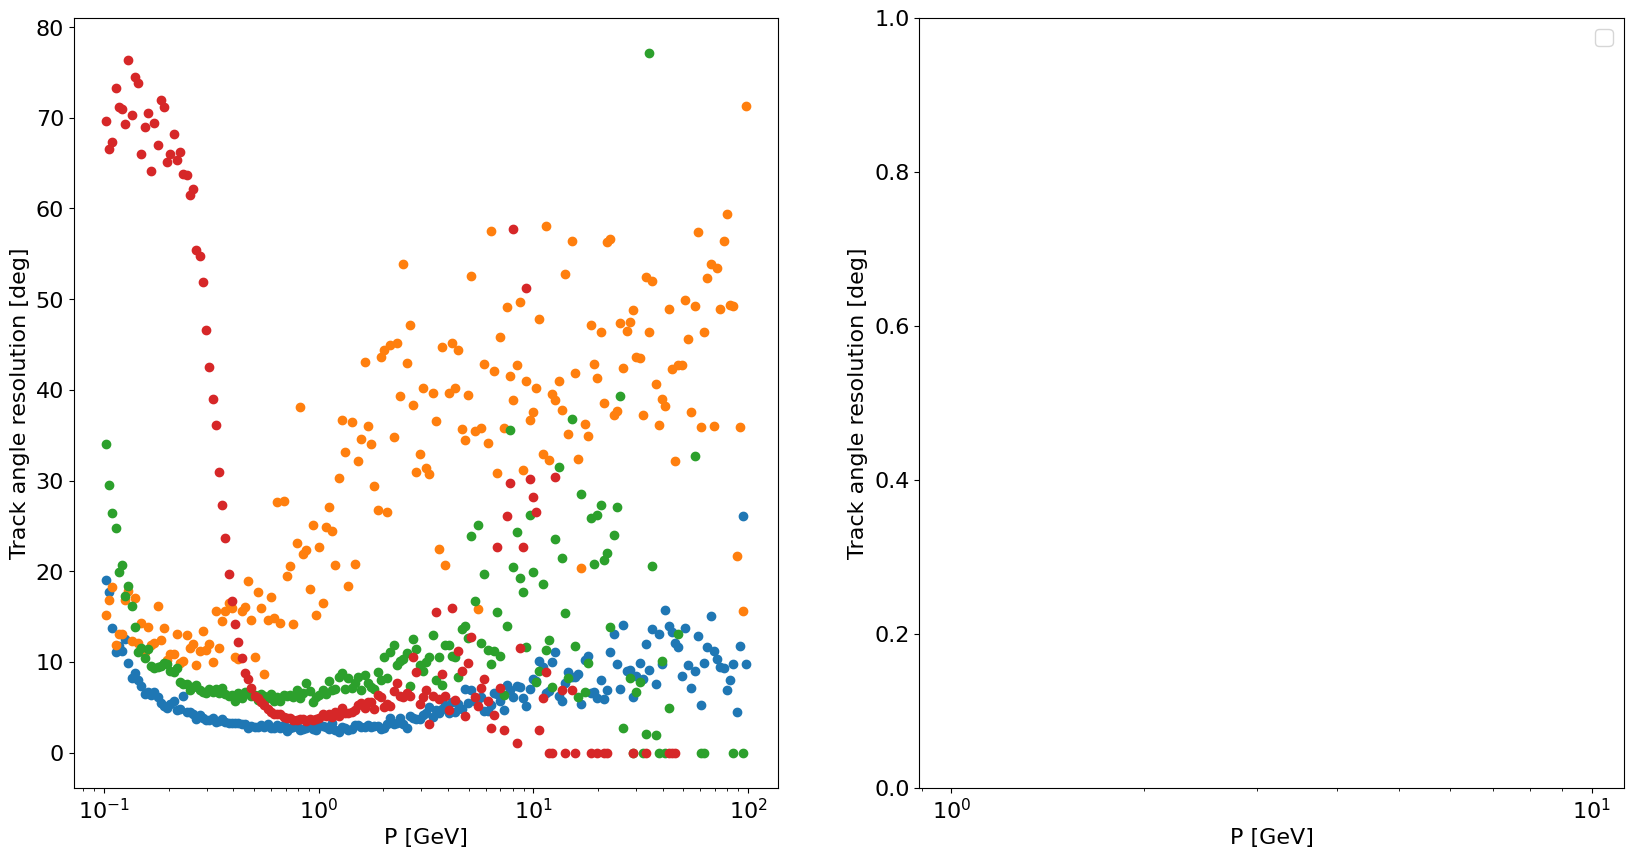

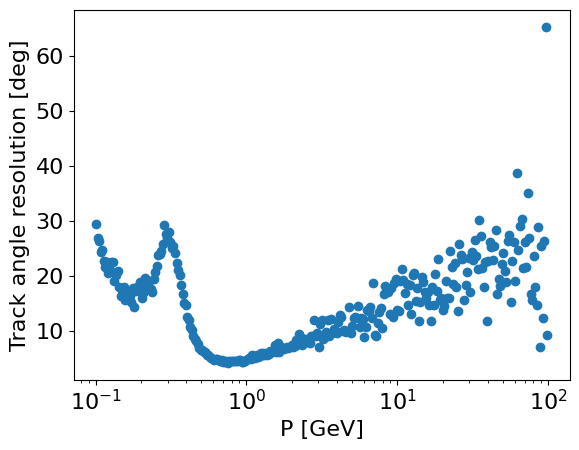

In [161]:
#Muon angle reconstruction
from particle import Particle

selected = pfp_merged.with_columns(
    theta_avg = (pl.col('trkenddcosy_pandoraTrack').arccos() + pl.col('trkstartdcosy_pandoraTrack').arccos())/2.
).with_columns(
    g4_dcosy = (pl.col('Py_geant')/pl.col('P_geant')).arccos(),
    reco_dcosy = pl.col('trkstartdcosy_pandoraTrack').arccos()
).with_columns(
    diff = (pl.col('g4_dcosy') - pl.col('reco_dcosy'))*180/np.pi,
    diff_avg = (pl.col('g4_dcosy') - pl.col('theta_avg'))*180/np.pi,
)

# std, _, _ = binned_statistic(result['Ev'], (result['nu_dcos_y'].arccos() - 0.5*result['mu_dcosy_end'].arccos() - 0.5*result['mu_dcosy_start'])*180/np.pi, statistic=manual_std, bins=Ebins)
# plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label="average direction")

Ebins = np.logspace(-1, 2, 200)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for pdg in [13, 11, 211, 2212]:
# for pdg in [11]:
    selected_events = selected.filter(
        pl.col('pdg_geant').abs() == pdg
    )
    std, _, _ = binned_statistic(selected_events['P_geant'], selected_events['diff'], statistic=manual_std, bins=Ebins)
    std_avg, _, _ = binned_statistic(selected_events['P_geant'], selected_events['diff_avg'], statistic=manual_std, bins=Ebins)
    axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label=rf"${Particle.from_pdgid(pdg).latex_name}$");
    # axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std_avg, label=rf"${Particle.from_pdgid(pdg).latex_name}$");


for ax in axs:
    ax.set_xscale('log')
    ax.set_xlabel('P [GeV]')
    ax.set_ylabel('Track angle resolution [deg]')
plt.legend(ncol=2)

plt.figure()

Ebins = np.logspace(-1, 2, 300)

std, _, _ = binned_statistic(selected['P_geant'], selected['diff'], statistic=manual_std, bins=Ebins)
plt.scatter(0.5*(Ebins[:-1] + Ebins[1:]), std);



plt.xscale('log')
plt.ylabel('Track angle resolution [deg]')
plt.xlabel('P [GeV]')
# plt.hist(selected['diff'], bins=200, range=(-8, 3));


    #     return (
    #         (pl.col(f'P{ax}_geant')/pl.col('P_geant')*pl.col('basic_momentum'))
    #         .filter(is_primary_reco())
    #         .filter(is_track())
    #         .drop_nulls()
    #         .sum()
    #     )
    # #Computing the total momentum of all the primary PFPs designed as tracks along a given axis
    # return ((pl.col(f'trkstartdcos{ax}_pandoraTrack')*pl.col('basic_momentum')) #trkmomrange_pandoraTrack
    #         .filter(is_primary_reco())
    #         .filter(is_track())
    #         # .filter(is_close_to_vertex(1000000))
    #         .drop_nulls()
    #         .sum())


In [44]:
selected['pdg_geant'].value_counts().sort('counts')

pdg_geant,counts
i32,u32
1000020060,1
1000190380,1
1000130260,1
1000110250,1
1000030080,1
1000060140,1
1000150340,1
1000150290,1
1000040070,1


In [12]:
display([elt for elt in pfp_merged.columns if 'geant' in elt])

['pdg_geant',
 'status_geant',
 'Mass_geant',
 'Eng_geant',
 'EndE_geant',
 'Px_geant',
 'Py_geant',
 'Pz_geant',
 'P_geant',
 'StartPointx_geant',
 'StartPointy_geant',
 'StartPointz_geant',
 'StartT_geant',
 'EndPointx_geant',
 'EndPointy_geant',
 'EndPointz_geant',
 'EndT_geant',
 'theta_geant',
 'phi_geant',
 'theta_xz_geant',
 'theta_yz_geant',
 'pathlen_geant',
 'inTPCActive_geant',
 'StartPointx_tpcAV_geant',
 'StartPointy_tpcAV_geant',
 'StartPointz_tpcAV_geant',
 'StartT_tpcAV_geant',
 'StartE_tpcAV_geant',
 'StartP_tpcAV_geant',
 'StartPx_tpcAV_geant',
 'StartPy_tpcAV_geant',
 'StartPz_tpcAV_geant',
 'EndPointx_tpcAV_geant',
 'EndPointy_tpcAV_geant',
 'EndPointz_tpcAV_geant',
 'EndT_tpcAV_geant',
 'EndE_tpcAV_geant',
 'EndP_tpcAV_geant',
 'EndPx_tpcAV_geant',
 'EndPy_tpcAV_geant',
 'EndPz_tpcAV_geant',
 'pathlen_drifted_geant',
 'inTPCDrifted_geant',
 'StartPointx_drifted_geant',
 'StartPointy_drifted_geant',
 'StartPointz_drifted_geant',
 'StartT_drifted_geant',
 'StartE_dri

['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']
['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']



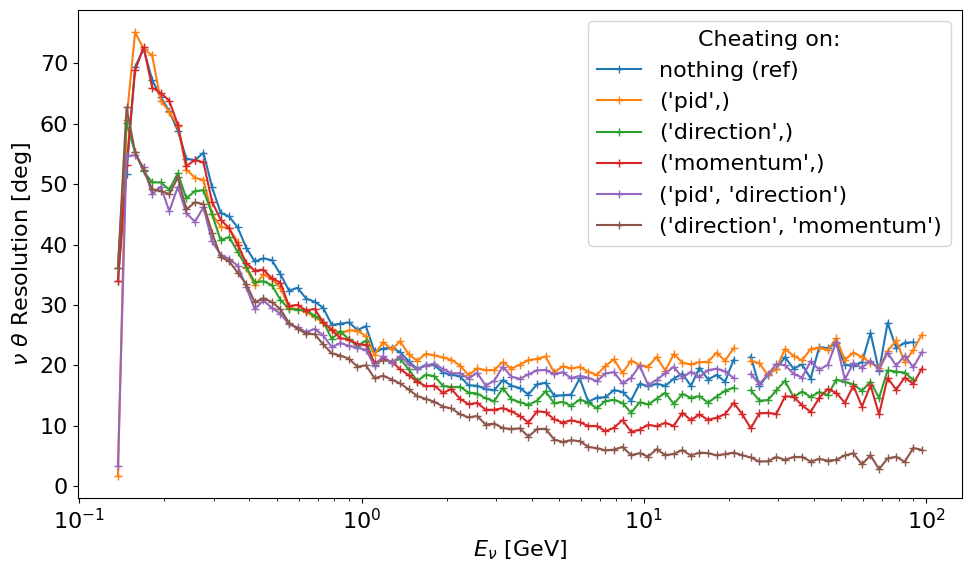

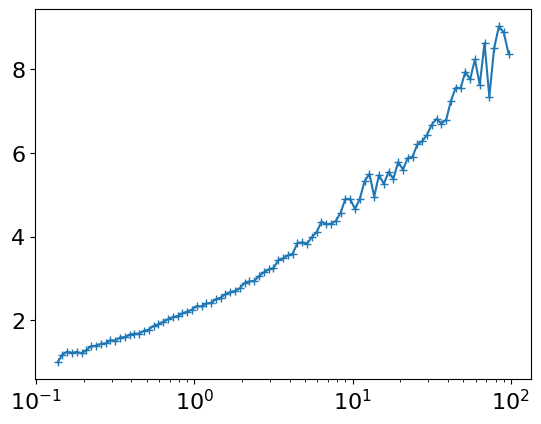

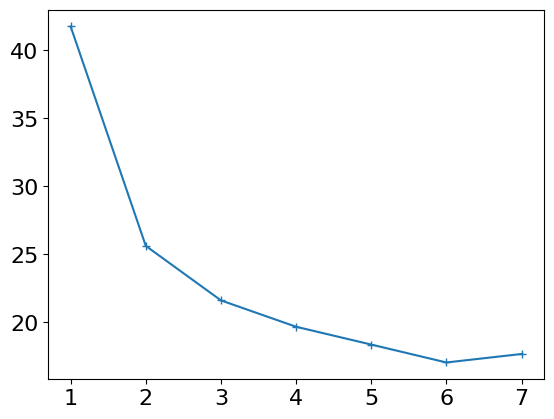

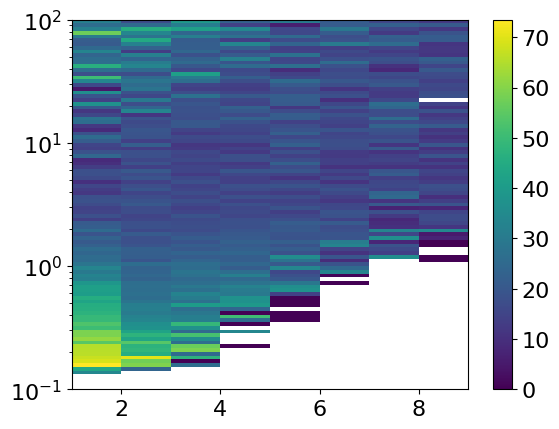

In [129]:
import itertools



def basic_pid(data:pl.DataFrame, pida_cut:float = 10, cheat:bool = False) -> pl.DataFrame:
    """
    Longest track is assumed to be the muon.
    Then a basic cut of PIDA=10 is used to separate protons from pions
    """

    if cheat:
        return data.with_columns(basic_pid = pl.col('pdg_geant'))

    longest_tracks = data.group_by(selection_events()).agg(
        pl.col('pfp_selfID')
            .sort_by('trklen_pandoraTrack')
            .filter(is_track())
            .filter(is_primary_reco())
            .last()
    ).with_columns(
        is_longest_track = True
    )

    # longest_tracks = data.group_by(selection_events()).agg(
    #     pl.col('pfp_selfID')
    #         .sort_by('trklen_pandoraTrack')
    #         .filter(is_track())
    #         .filter(is_primary_reco())
    #         .filter(pl.col('pdg_geant').abs() == 13)
    #         # .filter((pl.col('trkpdgtruth_pandoraTrack_x').abs() == 13) & (pl.col('trkpdgtruth_pandoraTrack_y').abs() == 13) & (pl.col('trkpdgtruth_pandoraTrack_z').abs() == 13))
    #         .last()
    # ).with_columns(
    #     is_longest_track = True
    # )

    new_data = data.join(
        longest_tracks,
        on=selection_events('pfp_selfID'),
        how='left').with_columns(
            pl.col('is_longest_track').fill_null(False)
        ).with_columns(
            basic_pid = pl.when(pl.col('is_longest_track')).then(13).otherwise(
                pl.when(pl.col('trkpidpida_pandoraTrack_z') < pida_cut)
                .then(211)
                .otherwise(2212)
            )
        )
    return new_data

def basic_momentum(cheat:bool = False) -> pl.Expr:
    if cheat:
        return pl.col('P_geant')
    return pl.when(pl.col('basic_pid') == 13).then(
        pl.col('trkmomrange_pandoraTrack')
    ).otherwise(
        pl.when(pl.col('basic_pid') == 211).then(
            (pl.col('trkke')*1e-3*(2*0.13957 + pl.col('trkke')*1e-3)).sqrt()
        ).otherwise(
            pl.when(pl.col('basic_pid') == 2212)
            .then(
                proton_momentum_by_range(pl.col('trklen_pandoraTrack'))
                # (pl.col('trkke')*1e-3*(2*0.938 + pl.col('trkke')*1e-3)).sqrt()
                ) 
            .otherwise(0)
        )
    )

def sum_p_reco(ax:str, cheat:bool = False) -> pl.Expr:
    if cheat:
        return (
            (pl.col(f'P{ax}_geant')/pl.col('P_geant')*pl.col('basic_momentum'))
            .filter(is_primary_reco())
            .filter(is_track())
            .drop_nulls()
            .sum()
        )
    #Computing the total momentum of all the primary PFPs designed as tracks along a given axis
    return ((pl.col(f'trkstartdcos{ax}_pandoraTrack')*pl.col('basic_momentum')) #trkmomrange_pandoraTrack
            .filter(is_primary_reco())
            .filter(is_track())
            # .filter(is_close_to_vertex(1000000))
            .drop_nulls()
            .sum())

def cosall(cheat:bool = False) -> pl.Expr:
    return (pl.when(sum_p_reco('y', cheat) != 0)
        .then(sum_p_reco('y', cheat)/(sum_p_reco('x', cheat)**2 + sum_p_reco('y', cheat)**2 + sum_p_reco('z', cheat)**2).sqrt())
    )

def compute_result(data:pl.DataFrame, cheat:list[str] = []) -> pl.DataFrame:
    cheat_pid = 'pid' in cheat
    cheat_direction = 'direction' in cheat
    cheat_momentum = 'momentum' in cheat
    
    return basic_pid(
        data
            .filter(pl.col('ccnc_truth') == 0)
            .filter(pl.col('nuPDG_truth').abs() == 14)
        , cheat=cheat_pid).with_columns(
            trkke = trkke()
        ).with_columns(
            basic_momentum = basic_momentum(cheat=cheat_momentum)
        ).group_by(selection_events()).agg(
            Ev = pl.col('enu_truth').first(),
            cos_y = pl.col('nu_dcosy_truth').first(),
            cos_y_lt = pl.col('trkstartdcosy_pandoraTrack').sort_by('trklen_pandoraTrack')
                    .filter(is_track())
                    .filter(is_primary_reco())                
                    .last(),
            cos_y_allt = cosall(cheat=cheat_direction),
            nb_tracks = pl.count(),
            nuPDG_truth = pl.col('nuPDG_truth').first()
    ).drop_nulls()


plt.figure(figsize=(10, 6))
Ebins = np.logspace(-1, 2, 100)
# std, _, _ = binned_statistic(results['Ev'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_lt']))*180/np.pi, 'std', Ebins)
# std2, _, _ = binned_statistic(results['Ev'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_allt']))*180/np.pi, 'std', Ebins)

cheatlist = ['pid', 'direction', 'momentum']
ref = compute_result(pfp_merged)
std_ref, _, _ = binned_statistic(results['Ev'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_allt']))*180/np.pi, statistic=manual_std, bins=Ebins)
std_ref = 0

for L in range(0, len(cheatlist) + 1):
    for subset in itertools.combinations(cheatlist, L):
        if 'pid' in subset and 'momentum' in subset:
            continue

        results = compute_result(pfp_merged, subset)
        if not subset:
            subset='nothing (ref)'
        std, _, _ = binned_statistic(results['Ev'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_allt']))*180/np.pi, statistic=manual_std, bins=Ebins)
        plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), std - std_ref, label=str(subset), marker='+')


# plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), std, color='magenta', label='std', marker='+')
# plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), std2, color='chartreuse', label='std2', marker='+')
plt.xscale('log')
plt.xlabel(r'$E_\nu$ [GeV]')
# plt.ylabel(r'Improvement in $\nu$ $\theta$ Resolution [deg]')
plt.ylabel(r'$\nu$ $\theta$ Resolution [deg]')
# plt.ylim(0, 75)
plt.legend(title='Cheating on:')
plt.tight_layout()


plt.figure()
results = compute_result(pfp_merged)
avg_tracks, _, _ = binned_statistic(results['Ev'], results['nb_tracks'], statistic='mean', bins=Ebins)
plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), avg_tracks, marker='+')
plt.xscale('log')

plt.figure()
results = compute_result(pfp_merged)
# ran = (np.linspace(0, 10, 10), np.linspace(-1, 1, 100))
bins = np.arange(1, 10)
std, _, _ = binned_statistic(results['nb_tracks'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_allt']))*180/np.pi, statistic=manual_std, bins=bins)
plt.plot(bins[:-1], std, marker='+')

plt.figure()
std, _, _, _ = binned_statistic_2d(results['nb_tracks'], results['Ev'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_allt']))*180/np.pi, statistic=manual_std, bins=(bins, Ebins))
plt.pcolormesh(bins, Ebins, std.T)
plt.colorbar()
plt.yscale('log')

# plt.hist2d(results['nb_tracks'] , (np.arccos(results['cos_y']) - np.arccos(results['cos_y_allt']))*180/np.pi, bins=ran)
print()
# plt.xscale('log')
# plt.hist(results['nb_tracks'], bins=10);

#Plot resolution vs nb tracks. Differentiate the tracks by reco flavour/true flavour


# results = results.filter(pl.col('Ev') <= 2).filter(pl.col('Ev') >= 1.5)


In [37]:
res1 = compute_result(pfp_merged, ['direction']) 
res2 = compute_result(pfp_merged, ['pid', 'direction'])

print(res1)
print(res2)

['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']
['subrun', 'event']
shape: (73_107, 6)
┌────────┬───────┬──────────┬───────────┬───────────┬────────────┐
│ subrun ┆ event ┆ Ev       ┆ cos_y     ┆ cos_y_lt  ┆ cos_y_allt │
│ ---    ┆ ---   ┆ ---      ┆ ---       ┆ ---       ┆ ---        │
│ i32    ┆ i32   ┆ f32      ┆ f32       ┆ f32       ┆ f32        │
╞════════╪═══════╪══════════╪═══════════╪═══════════╪════════════╡
│ 0      ┆ 5     ┆ 0.54219  ┆ -0.490022 ┆ -0.558435 ┆ 0.108719   │
│ 10001  ┆ 13    ┆ 0.337317 ┆ -0.112372 ┆ -0.730475 ┆ 0.273686   │
│ 10006  ┆ 12    ┆ 0.887917 ┆ 0.04813   ┆ -0.231797 ┆ -0.066421  │
│ 10013  ┆ 14    ┆ 1.150259 ┆ 0.997586  ┆ 0.651558  ┆ 0.864478   │
│ …      ┆ …     ┆ …        ┆ …         ┆ …         ┆ …          │
│ 14491  ┆ 15    ┆ 2.57923  ┆ 0.862868  ┆ 0.919942  ┆ 0.905432   │
│ 14493  ┆ 6     ┆ 2.224977 ┆ -0.634392 ┆ -0.581332 ┆ -0.181967  │
│ 14493  ┆ 20    ┆ 2.715457 ┆ 0.689187  ┆ 0.55334   ┆ 0.558576   │
│ 14495  ┆ 1    

['subrun', 'event']
['subrun', 'event', 'pfp_selfID']
['subrun', 'event']


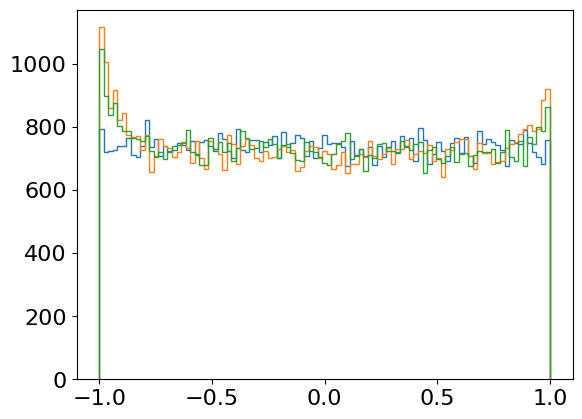

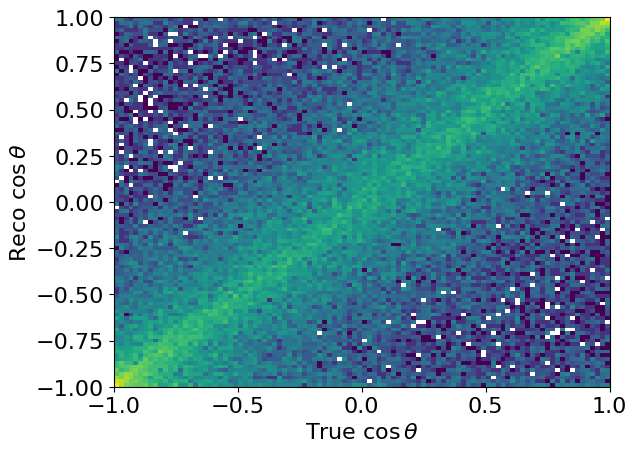

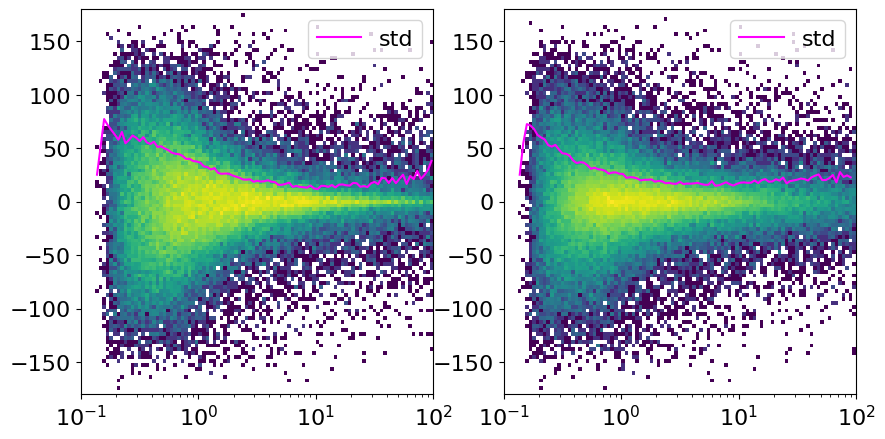

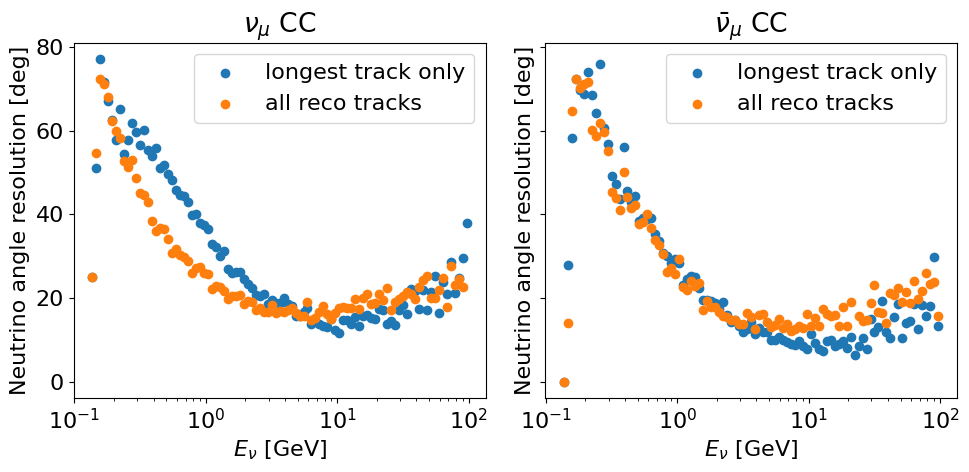

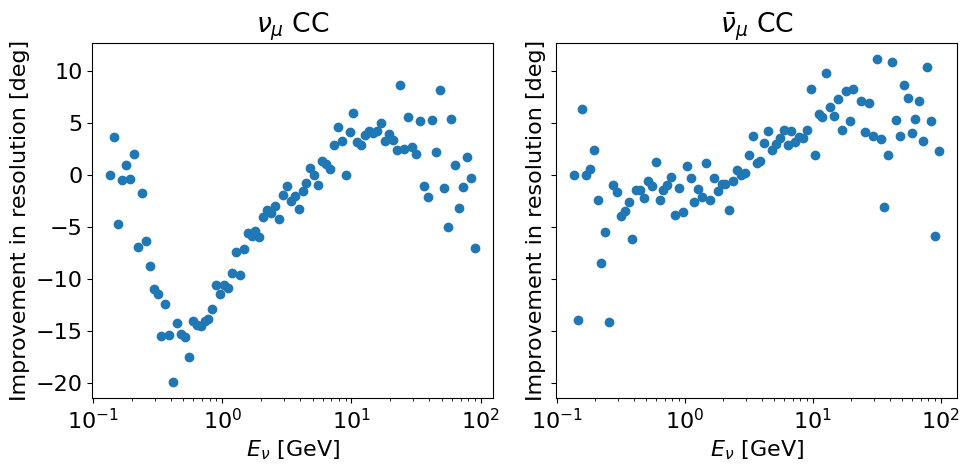

In [95]:
results = compute_result(pfp_merged)
fig, ax = plt.subplots(1, 1)
bins = np.linspace(-1, 1, 100)
hstat(results['cos_y'], ax, bins=bins, label="Truth", histtype='step');
hstat(results['cos_y_lt'], ax, bins=bins, label="Truth", histtype='step');
hstat(results['cos_y_allt'], ax, bins=bins, label="Truth", histtype='step');

plt.figure()
plt.hist2d(results['cos_y'], results['cos_y_lt'], bins=100, norm='log', range=((-1, 1), (-1, 1)));
plt.xlabel(r"True $\cos{\theta}$")
plt.ylabel(r"Reco $\cos{\theta}$")


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
cybins = np.linspace(-180, 180, 100)
Ebins = np.logspace(-1, 2, 100)
# hstat((np.arccos(results['cos_y']) - np.arccos(results['cos_y_lt']))*180/np.pi, ax, bins=bins, label="Lep only");

numu = results.filter(
    pl.col('nuPDG_truth') == 14
)

numubar = results.filter(
    pl.col('nuPDG_truth') == -14
)


axs[0].hist2d(results['Ev'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_lt']))*180/np.pi, bins=(Ebins, cybins), norm='log')

axs[1].hist2d(results['Ev'], (np.arccos(results['cos_y']) - np.arccos(results['cos_y_allt']))*180/np.pi, bins=(Ebins, cybins), norm='log')

std, _, _ = binned_statistic(numu['Ev'], (np.arccos(numu['cos_y']) - np.arccos(numu['cos_y_lt']))*180/np.pi, manual_std, Ebins)
std2, _, _ = binned_statistic(numu['Ev'], (np.arccos(numu['cos_y']) - np.arccos(numu['cos_y_allt']))*180/np.pi, manual_std, Ebins)
std3, _, _ = binned_statistic(numubar['Ev'], (np.arccos(numubar['cos_y']) - np.arccos(numubar['cos_y_lt']))*180/np.pi, manual_std, Ebins)
std4, _, _ = binned_statistic(numubar['Ev'], (np.arccos(numubar['cos_y']) - np.arccos(numubar['cos_y_allt']))*180/np.pi, manual_std, Ebins)


axs[0].plot(0.5*(Ebins[:-1] + Ebins[1:]), std, color='magenta', label='std')
axs[0].set_xscale('log')
axs[0].legend()
axs[1].plot(0.5*(Ebins[:-1] + Ebins[1:]), std2, color='magenta', label='std')
axs[1].set_xscale('log')
axs[1].legend()



fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std, label='longest track only')
axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std2, label='all reco tracks')
axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std3, label='longest track only')
axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std4, label='all reco tracks')
axs[0].set_title(r'$\nu_\mu$ CC')
axs[1].set_title(r'$\bar{\nu}_\mu$ CC')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('Neutrino angle resolution [deg]')
    ax.set_xlabel(r'$E_\nu$ [GeV]')
# plt.ylim(0, 75)
    ax.legend()
fig.tight_layout()

###############################################################
############################################################### RATIO
##############################################################

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axs[0].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std2-std, label='all reco tracks')
axs[1].scatter(0.5*(Ebins[:-1] + Ebins[1:]), std4-std3, label='all reco tracks')
axs[0].set_title(r'$\nu_\mu$ CC')
axs[1].set_title(r'$\bar{\nu}_\mu$ CC')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('Improvement in resolution [deg]')
    ax.set_xlabel(r'$E_\nu$ [GeV]')
# plt.ylim(0, 75)
    # ax.legend()
fig.tight_layout()

# plt.plot((-1, 1), (-1, 1), color='r', alpha=1)
# plt.axvline(0, color='red')
# plt.title("All primaries")


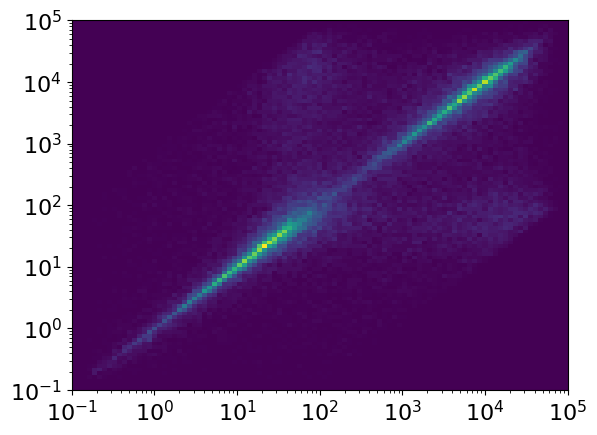

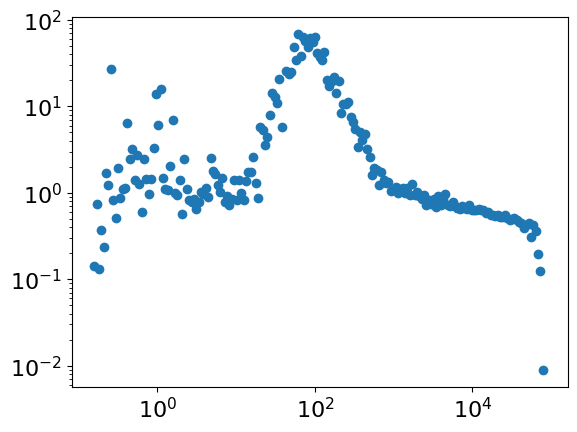

In [170]:
def compute_L(theta, a=15, L=6400):
    return L*np.sin(theta) + np.sqrt((L**2)*(np.sin(theta)**2) + a*(2*L + a))

theta = np.pi/2 - np.arccos(numu['cos_y'])
theta_reco = np.pi/2 - np.arccos(numu['cos_y_allt'])
L = compute_L(theta)
L_reco = compute_L(theta_reco)
plt.hist2d(L/numu['Ev'], L_reco/numu['Ev'], bins=(np.logspace(-1, 5, 100), np.logspace(-1, 5, 100)));
plt.xscale('log')
plt.yscale('log')
plt.figure()
bins = np.logspace(-1, 5, 200)
std, _, _ = binned_statistic(L/numu['Ev'], L_reco/L - 1, manual_std, bins=bins)
plt.scatter(0.5*(bins[1:] + bins[:-1]), std);
plt.xscale('log')
plt.yscale('log')

In [12]:

df = pid_eval(merged.filter(pl.col('has_valid_pfp') == 1))

In [77]:
pfp_merged.columns

['subrun',
 'event',
 'pfp_selfID',
 'pfp_isPrimary',
 'pfp_numDaughters',
 'pfp_vertexID',
 'pfp_isShower',
 'pfp_isTrack',
 'pfp_trackID',
 'pfp_showerID',
 'pfp_pdgCode',
 'pfp_isNeutrino',
 'trkId_pandoraTrack',
 'trkke_pandoraTrack_x',
 'trkke_pandoraTrack_y',
 'trkke_pandoraTrack_z',
 'trkrange_pandoraTrack_x',
 'trkrange_pandoraTrack_y',
 'trkrange_pandoraTrack_z',
 'trkidtruth_pandoraTrack_x',
 'trkidtruth_pandoraTrack_y',
 'trkidtruth_pandoraTrack_z',
 'trkorigin_pandoraTrack_x',
 'trkorigin_pandoraTrack_y',
 'trkorigin_pandoraTrack_z',
 'trkpdgtruth_pandoraTrack_x',
 'trkpdgtruth_pandoraTrack_y',
 'trkpdgtruth_pandoraTrack_z',
 'trkefftruth_pandoraTrack_x',
 'trkefftruth_pandoraTrack_y',
 'trkefftruth_pandoraTrack_z',
 'trkpurtruth_pandoraTrack_x',
 'trkpurtruth_pandoraTrack_y',
 'trkpurtruth_pandoraTrack_z',
 'trkpitchc_pandoraTrack_x',
 'trkpitchc_pandoraTrack_y',
 'trkpitchc_pandoraTrack_z',
 'ntrkhits_pandoraTrack_x',
 'ntrkhits_pandoraTrack_y',
 'ntrkhits_pandoraTrack_z'

/tmp/ipykernel_189651/3832469608.py:42: DeprecationWarning: using `min` for horizontal computation is deprecated. Use `min_horizontal` instead.
  min_pid = pl.min(f'trkpidpr_{type}',f'trkpidka_{type}', f'trkpidpi_{type}',f'trkpidmu_{type}')


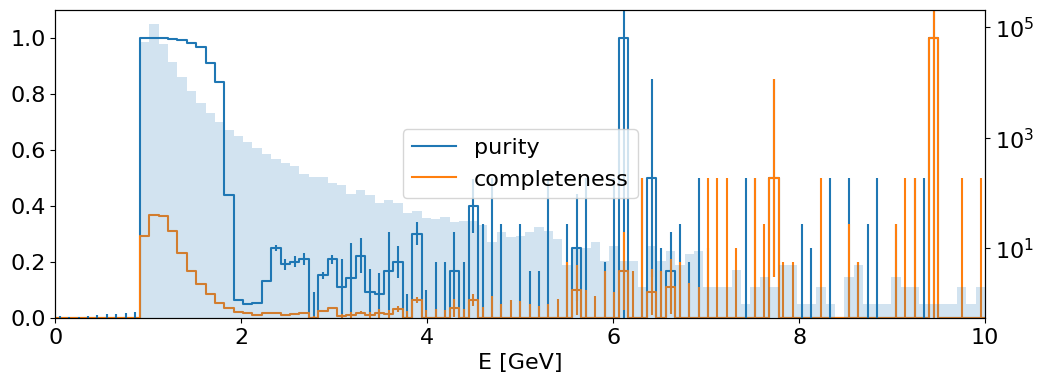

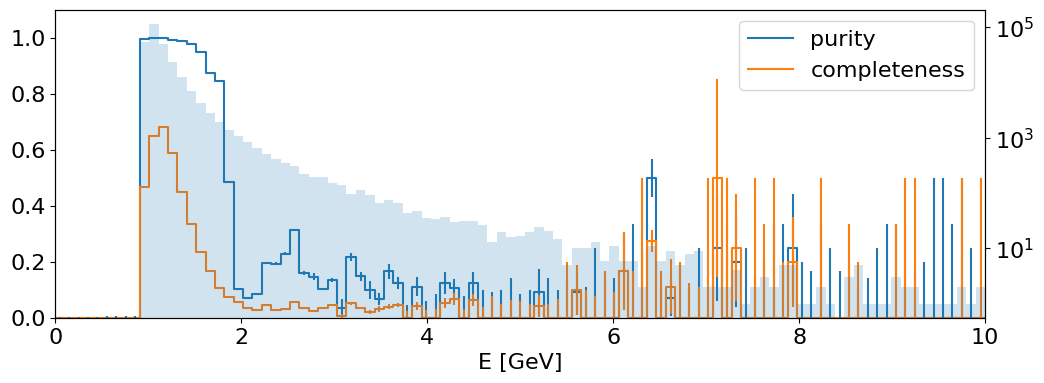

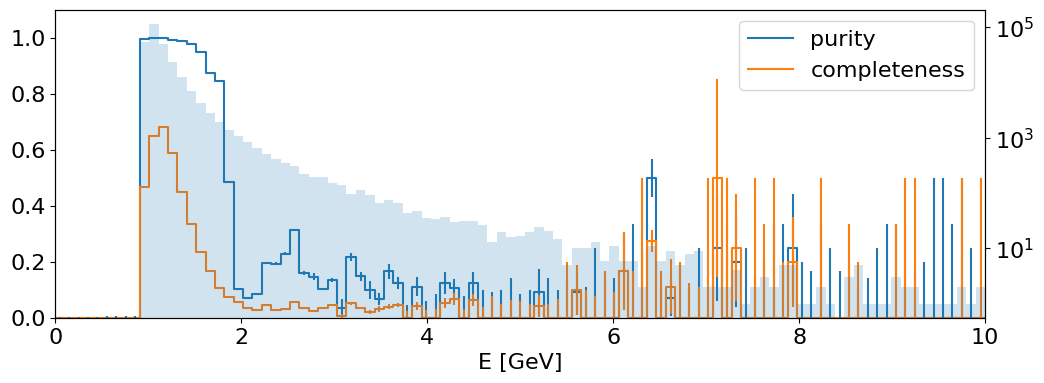

In [13]:
def fill_empty_categories(df, labels):

    empty_result = pl.DataFrame({ col: [0. for _ in labels] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=labels))

    # works, but need to add manually.
    # empty_result = pl.DataFrame({'purity': 0., 'completeness': 0., 'total_events':0., 'Ecut': labels})
    empty_result = empty_result.with_columns(Ecut=pl.col('Ecut').cast(pl.Int16))

    out = pl.concat([empty_result,df],how='diagonal')
    out = out.groupby('Ecut').agg(
        pl.all().sum()
        # purity = pl.col("purity").sum(),
        # completeness = pl.col("completeness").sum(),
    ).sort('Ecut')
    return out

def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

def purity_evolution(df, Ebins, flavour):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    cats = df.with_columns(
        # Ecut=df.get_column('Eng_geant').cut(Ebins, labels=labels).cast(pl.Int16),
        Ecut_text=pl.col('Eng_geant').cut(Ebins, labels=labels),
        Ecutt=pl.col('Eng_geant').cut(Ebins)
        ).with_columns(
            Ecut = pl.col('Ecut_text').cast(pl.Utf8).cast(pl.Int16)
        )
    q = (
        cats.groupby('Ecut').agg(
            correct_pdg = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            false_positive = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() != flavour).count().cast(pl.Float64),
            incorrect_pdg = pl.col('pid').filter(pl.col('pid') != flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            total_events = pl.col('pid').filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),

        ).fill_null(0).with_columns(
            purity = pl.col('correct_pdg')/
            (pl.col('correct_pdg') + pl.col("false_positive")),
            completeness = pl.col('correct_pdg') /
            (pl.col('correct_pdg') + pl.col("incorrect_pdg")),
        ).fill_nan(0).with_columns(
            err_correct_pdg = eval_err('correct_pdg'),
            err_false_positive = eval_err('false_positive'),
            err_incorrect_pdg = eval_err('incorrect_pdg'),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = eval_err_div('purity','correct_pdg','false_positive','err_correct_pdg','err_false_positive'),
            errcompleteness  = eval_err_div('completeness','correct_pdg','incorrect_pdg','err_correct_pdg','err_incorrect_pdg'),
        )
    )
    # bins_center = (Ebins[1:] + Ebins[:-1])*0.5
    bins_center = Ebins
    bins_width = np.diff(Ebins)
    q = fill_empty_categories(q, labels)
    fig = plt.figure(figsize=(12,4))
    p = plt.step(bins_center, q.get_column('purity')[:-1], label='purity')
    c = plt.step(bins_center, q.get_column('completeness')[:-1], label='completeness')

    error_center = (bins_center[1:] + bins_center[:-1])/2
    point_purity = q.get_column('purity')[1:-1]
    err_purity = q.get_column('errpurity')[1:-1]
    point_completeness = q.get_column('completeness')[1:-1]
    err_completeness = q.get_column('errcompleteness')[1:-1]
    plt.errorbar(error_center, point_purity,ls='none', marker='none', yerr=err_purity, color=p[0].get_color())
    plt.errorbar(error_center, point_completeness,ls='none', marker='none', yerr=err_completeness, color=c[0].get_color())
    plt.xlabel("E [GeV]")
    plt.xlim(bins_center[0], bins_center[-1])
    plt.ylim(0,1.1)
    plt.legend()
    # plt.xscale('log')
    ax2 = plt.twinx()

    ax2.bar(bins_center[:-1], q.get_column('total_events')[1:-1], width=bins_width, align="edge", alpha=0.2, log=True)
    ax2.grid(False)
    # return fig

Ebins = np.logspace(-1,2, 10)
Ebins = np.linspace(0.,10,100)


pdg = 2212
tracks_pid = particle_selection(df, type='av')
purity_evolution(tracks_pid, Ebins, pdg);

test_min = particle_selection(df, 'min')
purity_evolution(test_min, Ebins, pdg)

test_max = particle_selection(df, 'max')
purity_evolution(test_min, Ebins, pdg)

In [223]:
test = tracks_pid
Ebins = np.linspace(0.,10,100)
labels = list(map(str, np.arange(0, 101)))

test.select(
    E = pl.col('Eng_geant'),
    Ecut = pl.col('Eng_geant').cut(bins, labels),
    Ecutt = pl.col('Eng_geant').cut(bins),
)

E,Ecut,Ecutt
f32,cat,cat
1.085894,"""100""","""(1, inf]"""
0.161173,"""58""","""(0.15151515151…"
1.407522,"""100""","""(1, inf]"""
1.012064,"""100""","""(1, inf]"""
1.042059,"""100""","""(1, inf]"""
0.195867,"""60""","""(0.19191919191…"
0.120088,"""56""","""(0.11111111111…"
1.037418,"""100""","""(1, inf]"""
0.574085,"""78""","""(0.55555555555…"


/tmp/ipykernel_189651/3832469608.py:42: DeprecationWarning: using `min` for horizontal computation is deprecated. Use `min_horizontal` instead.
  min_pid = pl.min(f'trkpidpr_{type}',f'trkpidka_{type}', f'trkpidpi_{type}',f'trkpidmu_{type}')


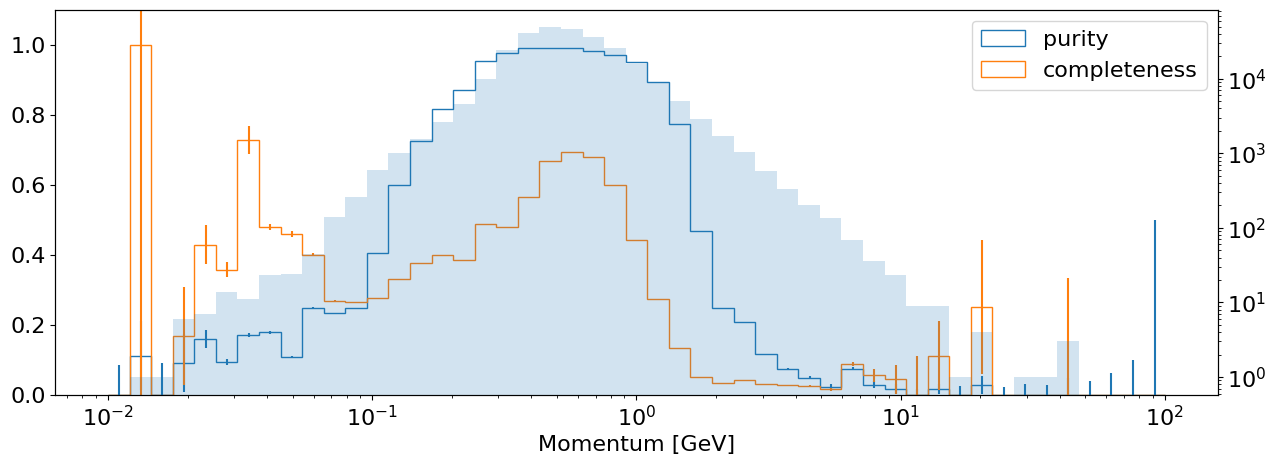

In [15]:
def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

def purity_evolution(
        df:pl.DataFrame,
        Ebins,
        flavour,
        E='P_geant',
        loc='best',
        fig=None,
        plot_purity = True,
        plot_completeness=True,
        plot_events=True,
        label='',
):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    cats:pl.DataFrame
    cats = df.with_columns(
        # Ecut=df.get_column('Eng_geant').cut(Ebins, labels=labels).cast(pl.Int16),
        Ecut_text=pl.col(E).cut(Ebins, include_breaks=True, labels=labels),
        Ecutt=pl.col(E).cut(Ebins).cast(pl.Utf8)
    ).unnest(
        'Ecut_text'
    ).with_columns(
            Ecut = pl.col(E+'_bin').cast(pl.Utf8).cast(pl.Int16),
            brk = pl.col('brk'),
        )
    # print(cats.group_by('Ecut').agg(pl.col('Ecutt').first(), count = pl.col(E).count(), brk=pl.col('brk').first()).sort('Ecut'))
    q = (
        cats.groupby('Ecut').agg(
            correct_pdg = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            false_positive = pl.col('pid').filter(pl.col('pid') == flavour).filter(
                pl.col('pdg_geant').abs() != flavour).count().cast(pl.Float64),
            incorrect_pdg = pl.col('pid').filter(pl.col('pid') != flavour).filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            total_events = pl.col('pid').filter(
                pl.col('pdg_geant').abs() == flavour).count().cast(pl.Float64),
            Ecutt = pl.col('Ecutt').first(),
            brk = pl.col('brk').first(),

        ).fill_null(0).with_columns(
            purity = pl.col('correct_pdg')/
            (pl.col('correct_pdg') + pl.col("false_positive")),
            completeness = pl.col('correct_pdg') /
            (pl.col('correct_pdg') + pl.col("incorrect_pdg")),
        ).fill_nan(0).with_columns(
            err_correct_pdg = eval_err('correct_pdg'),
            err_false_positive = eval_err('false_positive'),
            err_incorrect_pdg = eval_err('incorrect_pdg'),
        ).sort('Ecut').with_columns(
            errpurity = eval_err_div('purity','correct_pdg','false_positive','err_correct_pdg','err_false_positive'),
            errcompleteness  = eval_err_div('completeness','correct_pdg','incorrect_pdg','err_correct_pdg','err_incorrect_pdg'),
        )
    )
    bins = q.get_column('brk').to_list()
    intervals = q.get_column('Ecutt').to_list()
    start_point = intervals[0]
    end_point = intervals[-1]

    if 'inf' not in start_point: # if inf not in first line, add starting point to bins (breaks only have last part)
        start_point=start_point.replace('(',"*")
        start_point=start_point.replace(',',"*")
        re=float(start_point.split("*")[1])
        bins.insert(0,re)
    else: # if inf in the first line, skip the data (keep bins as starting point is here)
        q = q.tail(-1)

    if 'inf' not in end_point:
        # do nothing, everything set
        pass
    else: #discard last data and bin (inf is the break point)
        q = q.head(-1) 
        bins = bins[:-1]


    bins = np.array(bins)
    bins_center = (bins[1:] + bins[:-1])/2
    bins_width = np.diff(bins)
    # q = fill_empty_categories(q, labels)
    if fig is None:
        fig = plt.figure(figsize=(15,5))

    ax:plt.Axes
    ax = plt.gca()
    point_purity = q.get_column('purity')
    point_completeness = q.get_column('completeness')
    if plot_purity: p = ax.hist(bins[:-1], bins, weights=point_purity, label='purity'+label, histtype='step')
    if plot_completeness: c = ax.hist(bins[:-1], bins, weights=point_completeness, label='completeness'+label, histtype='step')

    error_center = bins_center
    err_purity = q.get_column('errpurity')
    err_completeness = q.get_column('errcompleteness')

    if plot_purity: ax.errorbar(error_center, point_purity,ls='none', marker='none', yerr=err_purity, color=p[2][0].get_facecolor()[:-1])
    if plot_completeness: ax.errorbar(error_center, point_completeness,ls='none', marker='none', yerr=err_completeness, color=c[2][0].get_facecolor()[:-1])
    ax.set_xlabel("Momentum [GeV]")
    # ax.xlim(bins_center[0], bins_center[-1])
    ax.set_ylim(0,1.1)
    ax.legend(loc=loc)
    ax.set_xscale('log')
    if plot_events:
        ax2 = ax.twinx()

        ax2.bar(bins[:-1], q.get_column('total_events'), width=bins_width, align="edge", alpha=0.2, log=True)
        ax2.grid(False)

    plt.sca(ax)        
    return q, bins

Ebins = np.logspace(-2,2, 50)
# Ebins = np.linspace(10.,20,10)


pdg = 2212
# tracks_pid = particle_selection(df, type='av')
# purity_evolution(tracks_pid, Ebins, pdg);

df = pid_eval(merged.filter(pl.col('has_valid_pfp') == 1))

test_min = particle_selection(df, 'min')
purity_evolution(test_min, Ebins, pdg);

# test_max = particle_selection(df, 'max')
# purity_evolution(test_min, Ebins, pdg)

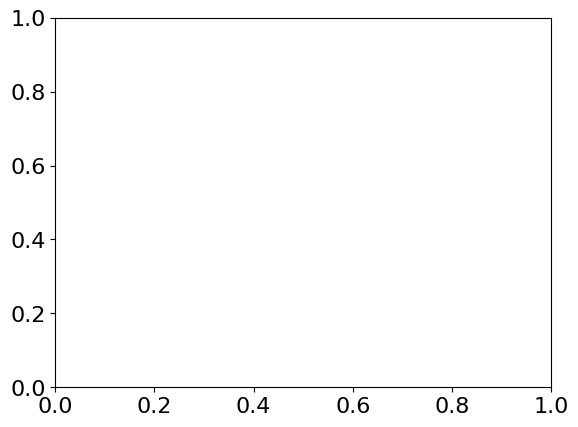

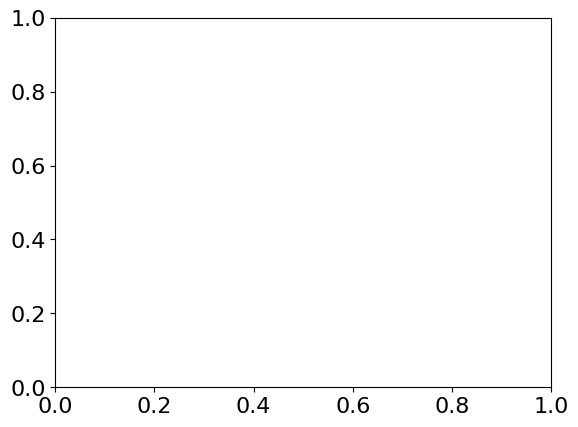

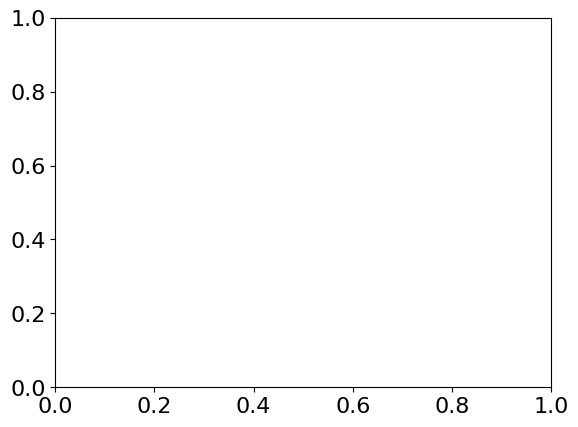

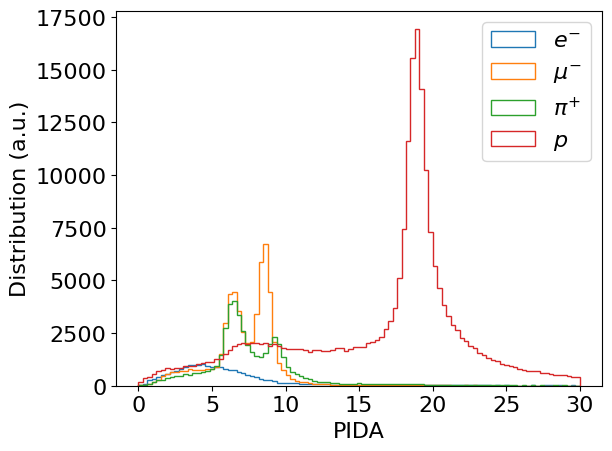

In [60]:
# plt.hist(pfp_merged['trkpidpida_pandoraTrack_x'], bins=np.linspace(0, 30, 100), histtype='step');
# plt.hist(pfp_merged['trkpidpida_pandoraTrack_y'], bins=np.linspace(0, 30, 100), histtype='step');
# plt.hist(pfp_merged['trkpidpida_pandoraTrack_z'], bins=np.linspace(0, 30, 100), histtype='step');

figures = [plt.subplots(1, 1)[1] for i in range(4)]


for pdg in [11, 13, 211, 2212]:
    selected = pfp_merged.filter(
        pdg == pl.col('trkpdgtruth_pandoraTrack_z')
        ).with_columns(
            pida_min = pl.min_horizontal(
                pl.col('trkpidpida_pandoraTrack_x'),
                pl.col('trkpidpida_pandoraTrack_y'),
                pl.col('trkpidpida_pandoraTrack_z')
                ),
            pida_max = pl.max_horizontal(
                pl.col('trkpidpida_pandoraTrack_x'),
                pl.col('trkpidpida_pandoraTrack_y'),
                pl.col('trkpidpida_pandoraTrack_z')
                ),
            pida_avg = pl.sum_horizontal(
                pl.col('trkpidpida_pandoraTrack_x'),
                pl.col('trkpidpida_pandoraTrack_y'),
                pl.col('trkpidpida_pandoraTrack_z')
                )/3.
        )
    # plt.sca(figures[0])
    # plt.hist(selected['trkpidpida_pandoraTrack_z'], bins=np.linspace(0, 30, 100), histtype='step', label=rf"${Particle.from_pdgid(pdg).latex_name}$");
    # plt.sca(figures[1])
    # plt.hist(selected['pida_min'], bins=np.linspace(0, 30, 100), histtype='step', label=rf"${Particle.from_pdgid(pdg).latex_name}$");
    plt.sca(figures[2])
    plt.hist(selected['pida_max'], bins=np.linspace(0, 30, 100), histtype='step', label=rf"${Particle.from_pdgid(pdg).latex_name}$");
    # plt.sca(figures[3])
    # plt.hist(selected['pida_avg'], bins=np.linspace(0, 30, 100), histtype='step', label=rf"${Particle.from_pdgid(pdg).latex_name}$");
plt.legend()
plt.ylabel("Distribution (a.u.)")
plt.xlabel("PIDA")
plt.tight_layout()


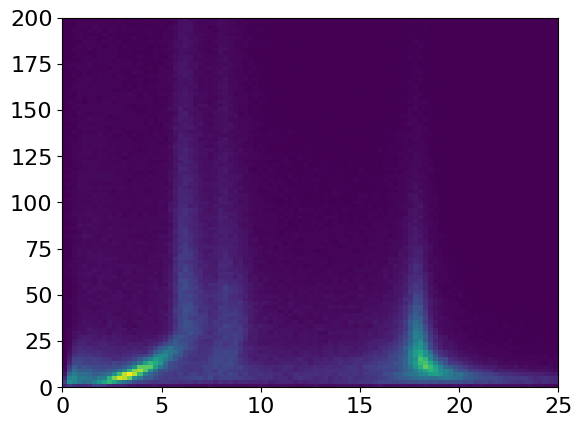

In [18]:
plt.hist2d(pfp_merged['trkpidpida_pandoraTrack_z'], pfp_merged['trklen_pandoraTrack'], bins=(np.linspace(0, 25, 100), np.linspace(0, 200, 100)));


[[<AxesSubplot: > <AxesSubplot: >]
 [<AxesSubplot: > <AxesSubplot: >]]


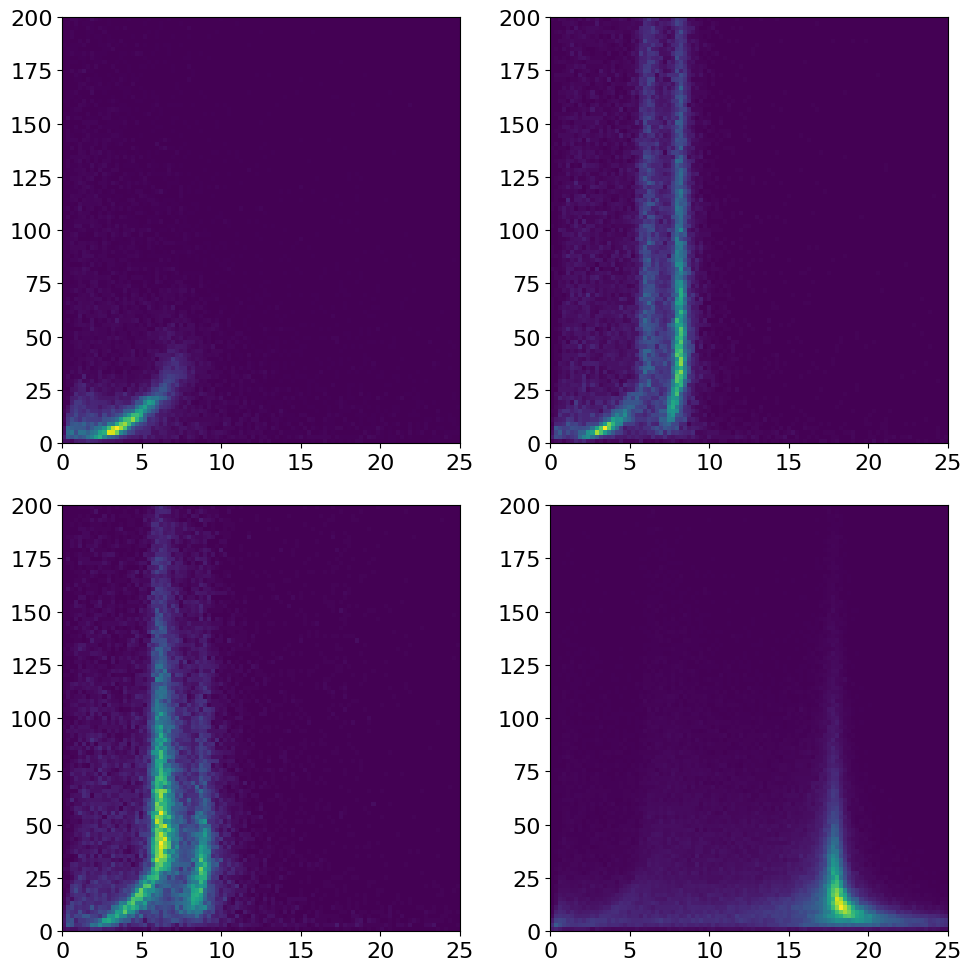

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
print(axs)

for i, pdg in enumerate([11, 13, 211, 2212]):
    row = i//2
    col = i%2
    selected = pfp_merged.filter(pdg == pl.col('trkpdgtruth_pandoraTrack_z'))
    axs[row, col].hist2d(selected['trkpidpida_pandoraTrack_z'], selected['trklen_pandoraTrack'], bins=(np.linspace(0, 25, 100), np.linspace(0, 200, 100)));

# plt.legend()
fig.tight_layout()

In [17]:
pfp_merged

subrun,event,pfp_selfID,pfp_isPrimary,pfp_numDaughters,pfp_vertexID,pfp_isShower,pfp_isTrack,pfp_trackID,pfp_showerID,pfp_pdgCode,pfp_isNeutrino,trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,trkorigin_pandoraTrack_x,trkorigin_pandoraTrack_y,trkorigin_pandoraTrack_z,trkpdgtruth_pandoraTrack_x,trkpdgtruth_pandoraTrack_y,trkpdgtruth_pandoraTrack_z,trkefftruth_pandoraTrack_x,trkefftruth_pandoraTrack_y,trkefftruth_pandoraTrack_z,trkpurtruth_pandoraTrack_x,trkpurtruth_pandoraTrack_y,trkpurtruth_pandoraTrack_z,trkpitchc_pandoraTrack_x,trkpitchc_pandoraTrack_y,trkpitchc_pandoraTrack_z,…,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,mode_truth,nuvtxx,nuvtxy,nuvtxz,div_pr_x,ndiv_x,div_pr_y,ndiv_y,div_pr_z,ndiv_z,trkpidpr_min,trkpidpr_av,trkpidpr_max,div_ka_x,div_ka_y,div_ka_z,trkpidka_min,trkpidka_av,trkpidka_max,div_pi_x,div_pi_y,div_pi_z,trkpidpi_min,trkpidpi_av,trkpidpi_max,div_mu_x,div_mu_y,div_mu_z,trkpidmu_min,trkpidmu_av,trkpidmu_max
i32,i32,i16,i16,i16,i16,i16,i16,i16,i16,i32,i16,i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,i16,i16,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f64,i32,f64,i32,f64,i32,f64,f64,i32,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,i32
0,1,1,0,0,1,0,1,1,-9999,13,0,1,136.64624,103.644913,139.777359,15.079591,14.20891,15.006312,5,5,5,1,1,1,2212,2212,2212,0.918819,0.824202,0.762844,1.0,1.0,1.0,0.977494,3.140232,1.245699,…,447.700287,525.584656,0.787418,-0.569203,0.452009,-0.686808,1,277.472595,448.944427,526.983948,1.085717,1,8.73717,1,0.376528,1,0.376528,3.399805,16,1.143296,5.852287,1.817984,1.143296,2.937855,16,2.665756,4.640295,5.791172,2.665756,4.365741,16,2.960257,6.366166,5.378572,2.960257,4.901665,16
0,2,1,0,0,1,0,1,1,-9999,13,0,1,8.951428,3.680822,-99999.0,3.709249,2.410001,-99999.0,2,4,-1,1,1,-1,11,2212,-99999,0.221642,0.89685,-99999.0,0.67843,0.591001,-1.0,0.48581,1.253273,-99999.0,…,193.297974,505.880768,0.197737,0.985746,0.000852,-0.168273,0,264.329041,195.713715,506.419067,42.930435,1,0.0,0,0.0,0,42.930435,42.930435,6,19.506012,0.0,0.0,19.506012,19.506012,6,4.386749,0.0,0.0,4.386749,4.386749,6,2.642678,0.0,0.0,2.642678,2.642678,6
0,4,0,0,0,0,0,1,0,-9999,13,0,0,463.107666,471.538269,477.121704,109.040665,109.936317,110.004295,287,287,287,1,1,1,2212,2212,2212,1.001051,0.892398,0.988572,0.95067,0.935315,0.948565,1.46499,0.696912,2.219433,…,-260.00061,201.680206,2.817654,-0.46573,-0.816682,-0.340778,1,37.700455,-407.680756,138.135696,6.444124,1,2.020943,1,7.777161,1,2.020943,5.414076,40,2.223087,0.722505,2.940321,0.722505,1.961971,40,0.468513,0.227363,0.667021,0.227363,0.454299,40,0.45594,0.215378,0.59256,0.215378,0.421293,40
0,4,1,0,0,1,0,1,1,-9999,13,0,1,41.658722,79.96769,42.096596,15.116651,17.100664,13.601286,559,4,559,1,1,1,2212,2212,2212,0.987047,0.864065,0.804968,0.399488,0.362853,0.370744,0.762289,1.200879,3.480614,…,-260.00061,201.680206,2.817654,-0.46573,-0.816682,-0.340778,1,37.700455,-407.680756,138.135696,8.660935,1,15.104879,1,50.085658,1,8.660935,24.617157,19,3.556216,3.980616,20.961294,3.556216,9.499375,19,0.477655,1.43547,1.905934,0.477655,1.273019,19,0.268064,1.000847,1.146439,0.268064,0.805117,19
0,4,2,0,0,2,0,1,2,-9999,13,0,2,66.608459,-99999.0,86.85836,5.70126,-99999.0,6.159606,4,-1,4,1,-1,1,2212,-99999,2212,0.983993,-99999.0,0.962342,1.0,-1.0,1.0,0.507878,-99999.0,0.84334,…,-260.00061,201.680206,2.817654,-0.46573,-0.816682,-0.340778,1,37.700455,-407.680756,138.135696,0.306843,1,0.0,0,1.312039,1,0.306843,0.809441,10,0.618117,0.0,0.75296,0.618117,0.685539,10,3.55319,0.0,3.235181,3.235181,3.394185,10,4.039787,0.0,3.620847,3.620847,3.830317,10
0,5,0,0,0,0,0,1,0,-9999,13,0,0,107.680252,94.48278,100.041451,26.238886,22.673147,25.713943,1,1,1,1,1,1,13,13,13,1.013033,0.977041,0.99857,0.86397,0.905212,

In [26]:
pfp_merged['trkpdgtruth_pandoraTrack_x']

trkpdgtruth_pandoraTrack_x
i32
2212
11
2212
2212
2212
13
22
2212
-13
